<a href="https://colab.research.google.com/github/eberthrosales/Redes/blob/main/Entrenamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***`Modelo de entrenamiento`***

🚀 INICIANDO PREDICTOR DE PRECIOS DE CASAS

📥 Cargando datos...
✅ Datos cargados: 1728 registros, 17 características
📊 Rango de precios: $5,000 - $775,000
📊 Precio promedio: $211,967

🔄 Entrenando modelo...

🏗️ Construyendo modelo...
✅ Modelo construido con arquitectura mejorada

✅ Entrenamiento completado en 150 épocas
📊 MSE: $10,784,937,984.00
📊 RMSE: $103,850.56
📊 MAE: $80,035.34
📊 R²: 0.0802

✅ MODELO LISTO - Creando interfaz interactiva...



Output()


📊 Visualizando métricas de entrenamiento...



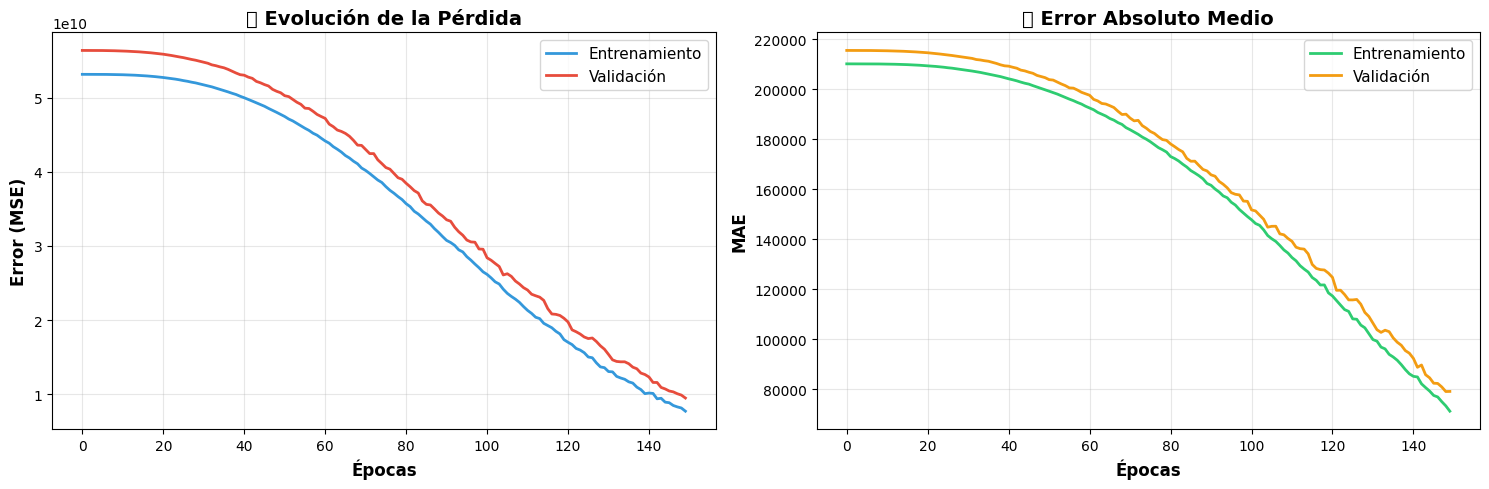

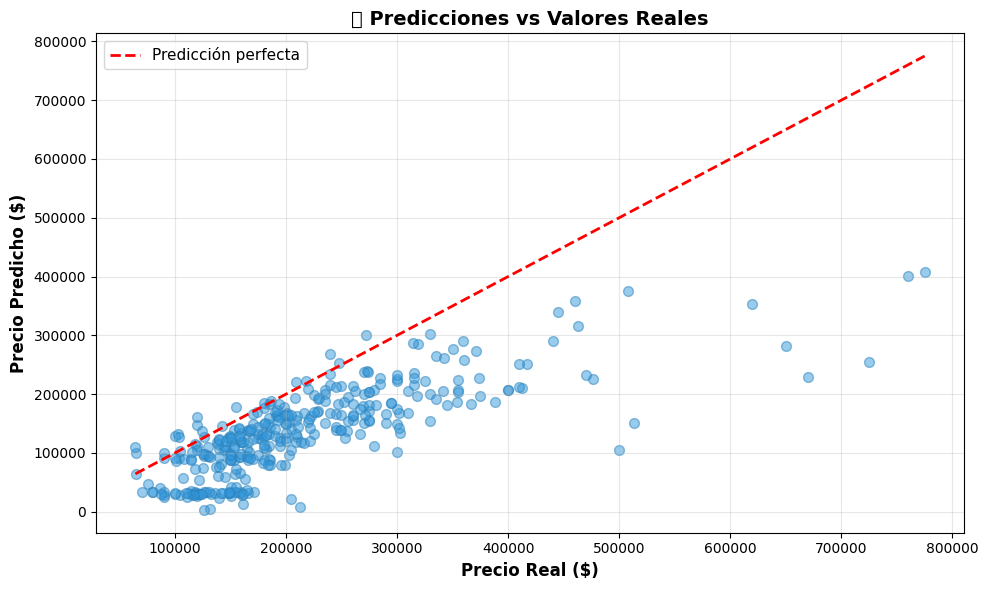


✅ ¡Sistema completamente operativo! Usa los widgets para hacer predicciones.


In [1]:
# ===============================
# 🔹 PREDICTOR DE PRECIOS - VERSIÓN MEJORADA
# ===============================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from ipywidgets import widgets, Layout
from IPython.display import display, HTML, clear_output
import warnings
warnings.filterwarnings('ignore')

# ===============================
# CLASE PRINCIPAL DEL PREDICTOR
# ===============================
class PredictorPrecios:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.columnas_finales = None
        self.history = None
        self.metricas = {}
        self.datos_originales = None
        self.opciones_categoricas = {}

    def cargar_datos(self, url):
        """Carga y preprocesa los datos"""
        print("📥 Cargando datos...")

        try:
            datos = pd.read_csv(url, sep=",")

            # Renombrar columnas
            datos.columns = ["precio", "metros_totales", "antiguedad", "precio_terreno",
                           "metros_habitables", "universitarios", "dormitorios",
                           "chimenea", "banyos", "habitaciones", "calefaccion",
                           "consumo_calefacion", "desague", "vistas_lago",
                           "nueva_construccion", "aire_acondicionado"]

            # Eliminar columna universitarios
            datos = datos.drop(columns=['universitarios'])

            # Guardar datos originales para análisis
            self.datos_originales = datos.copy()

            # Identificar columnas categóricas
            cat_cols = datos.select_dtypes(include=['object']).columns

            # Guardar opciones categóricas
            for col in cat_cols:
                self.opciones_categoricas[col] = ['Ninguno'] + datos[col].unique().tolist()

            # Convertir a dummies
            datos_dummies = pd.get_dummies(datos, columns=cat_cols, drop_first=True)

            # Separar características y target
            X = datos_dummies.drop('precio', axis=1)
            y = datos_dummies['precio'].values

            # Guardar nombres de columnas
            self.columnas_finales = X.columns.tolist()

            # Escalar características
            X_scaled = self.scaler.fit_transform(X)

            print(f"✅ Datos cargados: {len(datos)} registros, {X.shape[1]} características")
            print(f"📊 Rango de precios: ${y.min():,.0f} - ${y.max():,.0f}")
            print(f"📊 Precio promedio: ${y.mean():,.0f}")

            return X_scaled, y

        except Exception as e:
            print(f"❌ Error al cargar datos: {e}")
            raise

    def construir_modelo(self, input_dim):
        """Construye una red neuronal mejorada"""
        print("\n🏗️ Construyendo modelo...")

        model = Sequential([
            Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(0.3),

            Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(0.3),

            Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(0.2),

            Dense(16, activation='relu'),
            Dense(1, activation='linear')
        ])

        model.compile(
            optimizer='adam',
            loss='mse',
            metrics=['mae']
        )

        print("✅ Modelo construido con arquitectura mejorada")
        return model

    def entrenar(self, X, y, epochs=150, batch_size=32):
        """Entrena el modelo con callbacks"""
        print("\n🔄 Entrenando modelo...")

        # Dividir datos
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Construir modelo
        self.model = self.construir_modelo(X.shape[1])

        # Callbacks para mejor entrenamiento
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True,
                verbose=0
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7,
                verbose=0
            )
        ]

        # Entrenar
        self.history = self.model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0
        )

        # Evaluar
        y_pred = self.model.predict(X_test, verbose=0)

        self.metricas = {
            'mse': mean_squared_error(y_test, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
            'mae': mean_absolute_error(y_test, y_pred),
            'r2': r2_score(y_test, y_pred)
        }

        print(f"\n✅ Entrenamiento completado en {len(self.history.history['loss'])} épocas")
        print(f"📊 MSE: ${self.metricas['mse']:,.2f}")
        print(f"📊 RMSE: ${self.metricas['rmse']:,.2f}")
        print(f"📊 MAE: ${self.metricas['mae']:,.2f}")
        print(f"📊 R²: {self.metricas['r2']:.4f}")

        return X_test, y_test

    def preparar_entrada(self, df_entrada):
        """Prepara datos de entrada para predicción"""
        df_entrada = df_entrada.copy()
        df_entrada = pd.get_dummies(df_entrada, drop_first=True)

        # Asegurar que tiene todas las columnas necesarias
        for col in self.columnas_finales:
            if col not in df_entrada.columns:
                df_entrada[col] = 0

        # Mantener solo columnas del entrenamiento
        df_entrada = df_entrada[self.columnas_finales]

        # Escalar
        return self.scaler.transform(df_entrada)

    def predecir(self, datos_entrada):
        """Realiza una predicción"""
        entrada_scaled = self.preparar_entrada(datos_entrada)
        prediccion = self.model.predict(entrada_scaled, verbose=0)
        return prediccion[0][0]

    def obtener_estadisticas(self):
        """Retorna estadísticas del dataset"""
        if self.datos_originales is None:
            return None

        return {
            'precio_min': self.datos_originales['precio'].min(),
            'precio_max': self.datos_originales['precio'].max(),
            'precio_mean': self.datos_originales['precio'].mean(),
            'precio_median': self.datos_originales['precio'].median(),
            'total_propiedades': len(self.datos_originales)
        }

# ===============================
# CLASE PARA LA INTERFAZ
# ===============================
class InterfazPredictor:
    def __init__(self, predictor):
        self.predictor = predictor
        self.widgets = {}
        self.output = widgets.Output()

    def crear_widgets(self):
        """Crea todos los widgets de la interfaz"""
        style = {'description_width': '200px'}
        layout = Layout(width='400px')

        # Widgets numéricos con validación
        self.widgets['metros_totales'] = widgets.FloatText(
            value=2000, min=500, max=10000, step=50,
            description='🏠 Metros totales:', style=style, layout=layout
        )

        self.widgets['metros_habitables'] = widgets.FloatText(
            value=1500, min=300, max=8000, step=50,
            description='📐 Metros habitables:', style=style, layout=layout
        )

        self.widgets['antiguedad'] = widgets.FloatText(
            value=10, min=0, max=200, step=1,
            description='📅 Antigüedad (años):', style=style, layout=layout
        )

        self.widgets['precio_terreno'] = widgets.FloatText(
            value=50000, min=1000, max=1000000, step=1000,
            description='🌳 Precio del terreno:', style=style, layout=layout
        )

        self.widgets['dormitorios'] = widgets.IntSlider(
            value=3, min=1, max=8, step=1,
            description='🛏️ Dormitorios:', style=style, layout=layout,
            continuous_update=False
        )

        self.widgets['banyos'] = widgets.IntSlider(
            value=2, min=1, max=6, step=1,
            description='🚿 Baños:', style=style, layout=layout,
            continuous_update=False
        )

        self.widgets['habitaciones'] = widgets.IntSlider(
            value=7, min=3, max=15, step=1,
            description='🚪 Habitaciones totales:', style=style, layout=layout,
            continuous_update=False
        )

        self.widgets['chimenea'] = widgets.Dropdown(
            options=[('No', 0), ('Sí', 1)], value=0,
            description='🔥 Chimenea:', style=style, layout=layout
        )

        # Widgets categóricos
        opciones = self.predictor.opciones_categoricas

        self.widgets['calefaccion'] = widgets.Dropdown(
            options=opciones.get('calefaccion', ['Ninguno']),
            value='Ninguno', description='🌡️ Calefacción:', style=style, layout=layout
        )

        self.widgets['consumo'] = widgets.Dropdown(
            options=opciones.get('consumo_calefacion', ['Ninguno']),
            value='Ninguno', description='⚡ Consumo:', style=style, layout=layout
        )

        self.widgets['desague'] = widgets.Dropdown(
            options=opciones.get('desague', ['Ninguno']),
            value='Ninguno', description='💧 Desagüe:', style=style, layout=layout
        )

        self.widgets['vistas'] = widgets.Dropdown(
            options=opciones.get('vistas_lago', ['Ninguno']),
            value='Ninguno', description='🌊 Vistas al lago:', style=style, layout=layout
        )

        self.widgets['nueva'] = widgets.Dropdown(
            options=opciones.get('nueva_construccion', ['Ninguno']),
            value='Ninguno', description='🏗️ Nueva construcción:', style=style, layout=layout
        )

        self.widgets['aire'] = widgets.Dropdown(
            options=opciones.get('aire_acondicionado', ['Ninguno']),
            value='Ninguno', description='❄️ Aire acondicionado:', style=style, layout=layout
        )

        # Botones
        self.boton_predecir = widgets.Button(
            description='🔮 PREDECIR PRECIO',
            button_style='success',
            layout=Layout(width='400px', height='50px'),
            tooltip='Calcular precio estimado'
        )

        self.boton_limpiar = widgets.Button(
            description='🔄 LIMPIAR',
            button_style='warning',
            layout=Layout(width='400px', height='50px'),
            tooltip='Restablecer valores'
        )

        # Conectar eventos
        self.boton_predecir.on_click(self._predecir_precio)
        self.boton_limpiar.on_click(self._limpiar_campos)

    def _validar_entrada(self):
        """Valida la entrada del usuario"""
        errores = []

        if self.widgets['metros_habitables'].value > self.widgets['metros_totales'].value:
            errores.append("⚠️ Los metros habitables no pueden ser mayores que los metros totales")

        if self.widgets['dormitorios'].value > self.widgets['habitaciones'].value:
            errores.append("⚠️ Los dormitorios no pueden ser más que las habitaciones totales")

        return errores

    def _predecir_precio(self, b):
        """Maneja la predicción con validación"""
        with self.output:
            clear_output()

            # Validar entrada
            errores = self._validar_entrada()
            if errores:
                display(HTML(f"""
                <div style='background-color: #f8d7da; padding: 15px; border-radius: 10px; border: 2px solid #f5c6cb;'>
                    <h3 style='color: #721c24;'>❌ Errores de validación:</h3>
                    <ul style='color: #721c24;'>
                        {''.join(f'<li>{error}</li>' for error in errores)}
                    </ul>
                </div>
                """))
                return

            try:
                # Crear diccionario de entrada
                entrada_dict = {
                    'metros_totales': self.widgets['metros_totales'].value,
                    'antiguedad': self.widgets['antiguedad'].value,
                    'precio_terreno': self.widgets['precio_terreno'].value,
                    'metros_habitables': self.widgets['metros_habitables'].value,
                    'dormitorios': self.widgets['dormitorios'].value,
                    'chimenea': self.widgets['chimenea'].value,
                    'banyos': self.widgets['banyos'].value,
                    'habitaciones': self.widgets['habitaciones'].value
                }

                # Agregar categorías
                categorias = ['calefaccion', 'consumo', 'desague', 'vistas', 'nueva', 'aire']
                nombres_columnas = ['calefaccion', 'consumo_calefacion', 'desague',
                                  'vistas_lago', 'nueva_construccion', 'aire_acondicionado']

                for widget_key, col_name in zip(categorias, nombres_columnas):
                    if self.widgets[widget_key].value != 'Ninguno':
                        entrada_dict[col_name] = self.widgets[widget_key].value

                # Crear DataFrame
                entrada_manual = pd.DataFrame([entrada_dict])

                # Predecir
                precio_estimado = self.predictor.predecir(entrada_manual)

                # Obtener estadísticas
                stats = self.predictor.obtener_estadisticas()

                # Calcular percentil
                percentil = (precio_estimado < stats['precio_max']) * 100

                # Mostrar resultado
                display(HTML(f"""
                <div style='background-color: #d4edda; padding: 25px; border-radius: 15px; border: 3px solid #28a745; box-shadow: 0 4px 6px rgba(0,0,0,0.1);'>
                    <h2 style='color: #155724; text-align: center; margin-bottom: 10px;'>💰 PRECIO ESTIMADO</h2>
                    <h1 style='color: #155724; text-align: center; font-size: 56px; margin: 20px 0;'>${precio_estimado:,.2f}</h1>
                    <p style='text-align: center; color: #155724; font-size: 14px;'>
                        ± ${self.predictor.metricas['mae']:,.0f} (Error promedio del modelo)
                    </p>
                </div>
                <br>
                <div style='background-color: #d1ecf1; padding: 20px; border-radius: 10px; border: 1px solid #bee5eb;'>
                    <h3 style='color: #0c5460;'>📋 Resumen de la propiedad:</h3>
                    <ul style='color: #0c5460; font-size: 16px; line-height: 1.8;'>
                        <li>🏠 <strong>{entrada_dict['metros_totales']:.0f} m²</strong> totales (<strong>{entrada_dict['metros_habitables']:.0f} m²</strong> habitables)</li>
                        <li>🛏️ <strong>{entrada_dict['dormitorios']}</strong> dormitorios, <strong>{entrada_dict['banyos']}</strong> baños, <strong>{entrada_dict['habitaciones']}</strong> habitaciones totales</li>
                        <li>📅 <strong>{entrada_dict['antiguedad']:.0f}</strong> años de antigüedad</li>
                        <li>🌳 Terreno valorado en <strong>${entrada_dict['precio_terreno']:,.2f}</strong></li>
                        <li>🔥 Chimenea: <strong>{'Sí' if entrada_dict['chimenea'] == 1 else 'No'}</strong></li>
                    </ul>
                </div>
                <br>
                <div style='background-color: #fff3cd; padding: 15px; border-radius: 10px; border: 1px solid #ffeaa7;'>
                    <h4 style='color: #856404;'>📊 Contexto del mercado:</h4>
                    <p style='color: #856404; font-size: 14px;'>
                        • Precio mínimo en dataset: <strong>${stats['precio_min']:,.0f}</strong><br>
                        • Precio máximo en dataset: <strong>${stats['precio_max']:,.0f}</strong><br>
                        • Precio promedio: <strong>${stats['precio_mean']:,.0f}</strong><br>
                        • Precio mediano: <strong>${stats['precio_median']:,.0f}</strong>
                    </p>
                </div>
                """))

            except Exception as e:
                display(HTML(f"""
                <div style='background-color: #f8d7da; padding: 20px; border-radius: 10px; border: 2px solid #f5c6cb;'>
                    <h3 style='color: #721c24;'>❌ Error al realizar la predicción:</h3>
                    <p style='color: #721c24;'>{str(e)}</p>
                </div>
                """))

    def _limpiar_campos(self, b):
        """Limpia todos los campos"""
        self.widgets['metros_totales'].value = 2000
        self.widgets['metros_habitables'].value = 1500
        self.widgets['antiguedad'].value = 10
        self.widgets['precio_terreno'].value = 50000
        self.widgets['dormitorios'].value = 3
        self.widgets['banyos'].value = 2
        self.widgets['habitaciones'].value = 7
        self.widgets['chimenea'].value = 0

        for key in ['calefaccion', 'consumo', 'desague', 'vistas', 'nueva', 'aire']:
            self.widgets[key].value = 'Ninguno'

        with self.output:
            clear_output()
            print("✅ Campos restablecidos")

    def mostrar(self):
        """Muestra la interfaz completa"""
        display(HTML("""
        <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 30px; border-radius: 15px; margin-bottom: 20px;'>
            <h1 style='color: white; text-align: center; font-size: 36px; margin: 0;'>🏠 PREDICTOR DE PRECIOS DE CASAS</h1>
            <p style='color: white; text-align: center; font-size: 16px; margin-top: 10px;'>Modelo de Deep Learning con Red Neuronal</p>
        </div>
        """))

        # Organizar en columnas
        col1 = widgets.VBox([
            widgets.HTML("<h3 style='color: #34495e; background-color: #ecf0f1; padding: 10px; border-radius: 5px;'>📐 Características Físicas</h3>"),
            self.widgets['metros_totales'],
            self.widgets['metros_habitables'],
            self.widgets['antiguedad'],
            self.widgets['precio_terreno']
        ])

        col2 = widgets.VBox([
            widgets.HTML("<h3 style='color: #34495e; background-color: #ecf0f1; padding: 10px; border-radius: 5px;'>🏡 Distribución Interior</h3>"),
            self.widgets['dormitorios'],
            self.widgets['banyos'],
            self.widgets['habitaciones'],
            self.widgets['chimenea']
        ])

        col3 = widgets.VBox([
            widgets.HTML("<h3 style='color: #34495e; background-color: #ecf0f1; padding: 10px; border-radius: 5px;'>✨ Características Adicionales</h3>"),
            self.widgets['calefaccion'],
            self.widgets['consumo'],
            self.widgets['desague'],
            self.widgets['vistas'],
            self.widgets['nueva'],
            self.widgets['aire']
        ])

        display(widgets.HBox([col1, col2, col3]))
        display(widgets.HBox([self.boton_predecir, self.boton_limpiar]))
        display(self.output)

# ===============================
# FUNCIÓN PRINCIPAL
# ===============================
def main():
    print("="*70)
    print("🚀 INICIANDO PREDICTOR DE PRECIOS DE CASAS")
    print("="*70 + "\n")

    # URL de datos
    url = ("https://raw.githubusercontent.com/JoaquinAmatRodrigo/"
           "Estadistica-machine-learning-python/master/data/SaratogaHouses.csv")

    # Crear predictor
    predictor = PredictorPrecios()

    # Cargar y entrenar
    X, y = predictor.cargar_datos(url)
    X_test, y_test = predictor.entrenar(X, y)

    # Crear y mostrar interfaz
    print("\n" + "="*70)
    print("✅ MODELO LISTO - Creando interfaz interactiva...")
    print("="*70 + "\n")

    interfaz = InterfazPredictor(predictor)
    interfaz.crear_widgets()
    interfaz.mostrar()

    # Mostrar gráficos de entrenamiento
    print("\n📊 Visualizando métricas de entrenamiento...\n")

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Gráfico de pérdida
    axes[0].plot(predictor.history.history['loss'], label='Entrenamiento', linewidth=2, color='#3498db')
    axes[0].plot(predictor.history.history['val_loss'], label='Validación', linewidth=2, color='#e74c3c')
    axes[0].set_xlabel('Épocas', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Error (MSE)', fontsize=12, fontweight='bold')
    axes[0].set_title('📉 Evolución de la Pérdida', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Gráfico de MAE
    axes[1].plot(predictor.history.history['mae'], label='Entrenamiento', linewidth=2, color='#2ecc71')
    axes[1].plot(predictor.history.history['val_mae'], label='Validación', linewidth=2, color='#f39c12')
    axes[1].set_xlabel('Épocas', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('MAE', fontsize=12, fontweight='bold')
    axes[1].set_title('📊 Error Absoluto Medio', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Predicciones vs Real
    y_pred_test = predictor.model.predict(X_test, verbose=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(y_test, y_pred_test, alpha=0.5, s=50, color='#3498db', edgecolors='#2980b9')
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
            'r--', lw=2, label='Predicción perfecta')
    ax.set_xlabel('Precio Real ($)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Precio Predicho ($)', fontsize=12, fontweight='bold')
    ax.set_title('🎯 Predicciones vs Valores Reales', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n✅ ¡Sistema completamente operativo! Usa los widgets para hacer predicciones.")

# Ejecutar
if __name__ == "__main__":
    main()